In [110]:
import os
import sys
import json
import yaml
import cv2
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatch
import matplotlib
%matplotlib inline
# sys.path.append('../src/cyolo_utils')

# Set-up

In [2]:
!pwd

/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/src/notebooks_and_tools


In [3]:
home_path = '/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/src/' # copy the pwd minus notebook

In [4]:
rel_path = os.path.join('runs', 'train')
rel_path

'runs/train'

In [5]:
path = os.path.join(home_path, rel_path)
# path = os.path.join(os.curdir, '/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/src/', rel_path)
default_exp_prefix = 'exp'

In [7]:
# experiments of interests
exp_no_baseline = 23
exp_no_cyolo = 23

metadata = {'baseline': {'name': 'yolo', 'exp_id': exp_no_baseline},
 'contribution': {'name': 'cyolo', 'exp_id': exp_no_cyolo}}
metadata

{'baseline': {'name': 'yolo', 'exp_id': 23},
 'contribution': {'name': 'cyolo', 'exp_id': 23}}

In [24]:
# define a function to read experiments 
def read_exp(exp_no, exp_prefix=default_exp_prefix, path=home_path):
    exp_name = f'{exp_prefix}{exp_no}'
    exp_path = os.path.join(path, exp_name)
    res_file_name = os.path.join(exp_path, 'results.csv')
    results_df = pd.read_csv(res_file_name)
    pred = json.load(open(os.path.join(exp_path, '_predictions.json'))) 
    hyp = yaml.safe_load(open(os.path.join(exp_path, 'hyp.yaml'))) 
    opt = yaml.safe_load(open(os.path.join(exp_path, 'opt.yaml'))) 
#     cm_path = os.path.join(exp_path, 'confusion_matrix_abs_0.25.png')
#     cm = plt.imread(cm_path)
    return {'results': results_df, 'pred': pred, 'hyp': hyp, 'opt': opt}

In [156]:
def get_im_boxes_map(preds):
    im_boxes_map = defaultdict(list)
    for pred in tqdm(preds):
        im_id = pred['image_id']
        im_boxes_map[im_id].append({k:v for k, v in pred.items() if k != 'image_id'})
    im_boxes_map = dict(im_boxes_map)
    im_names = list(sorted(im_boxes_map))
    return im_boxes_map, im_names

In [25]:
exp_no = metadata['baseline']['exp_id']
exp_results = read_exp(exp_no, path = path)
exp_results.keys()

dict_keys(['results', 'pred', 'hyp', 'opt'])

In [ ]:
# read preds from baseline
exp_no = metadata['baseline']['exp_id']
exp_results = read_exp(exp_no, path = path)
yolo_preds = exp_results['pred']
yolo_im_boxes_map, yolo_im_names = get_im_boxes_map(yolo_preds)

In [158]:
# read preds from crowd-yolo
exp_no = metadata['contribution']['exp_id']
exp_results = read_exp(exp_no, path = path)
cyolo_preds = exp_results['pred']
cyolo_im_boxes_map, cyolo_im_names = get_im_boxes_map(cyolo_preds)

  0%|          | 0/2881 [00:00<?, ?it/s]

# Crowd-YOLO/YOLO predctions

In [209]:
# Crowd-YOLO predictions:

# set the correct directory
data_path = '/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/data/datasets'
# label_data_path = 'Zoon_50min_2perImg_IID/labels/val' # or val if want expert labels
image_data_path = 'single_toy_iid/images/val' # can change dataset as well
# la_path = os.path.join(data_path, label_data_path)
im_path = os.path.join(data_path, image_data_path)

# define class names, color and threshold for classes
class_names = ['BL', 'DC']
box_color_map = {'BL':'r', 'DC': 'b'}
conf_thres = {'BL': 0.0019, 'DC': 0.0076} ### need to change after read the score predicted

# image name:
print(cyolo_im_names)

# optional: check the class and score
# for item in im_label_info:
#     print(item['category_id'], item['score'])

['IS20180614_161235_0835_000000CD.Jonathan', 'IS20190716_144902_0220_000026F3.Jonathan']


/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/data/datasets/single_toy_iid/images/val/IS20180614_161235_0835_000000CD.Jonathan.jpg
(710, 939, 3)
710 939


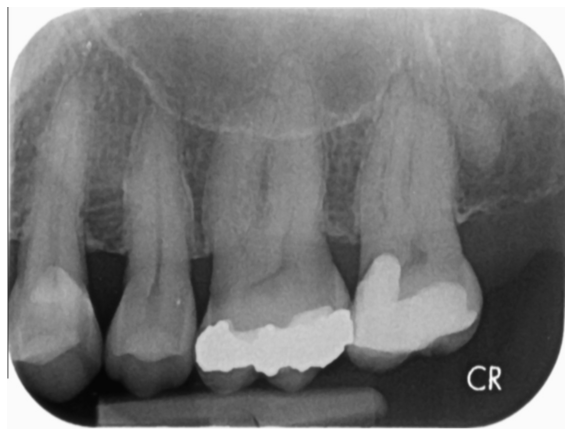

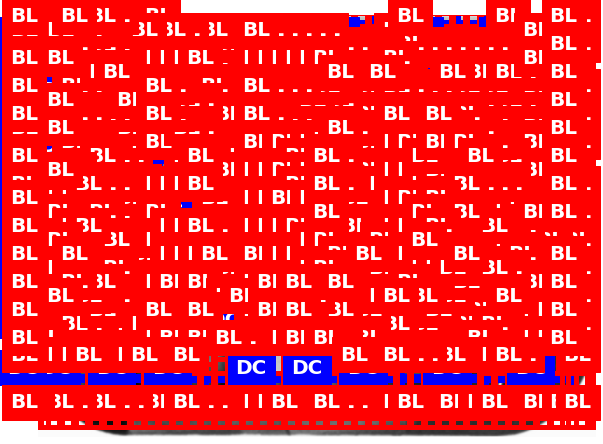

In [210]:
# select an image from the previous list
im_name = 'IS20180614_161235_0835_000000CD.Jonathan'

# extract the pred from the selected image:
im_label_info = cyolo_im_boxes_map[im_name]

# select the image/label and get the dir:
im_filepath = os.path.join(im_path, im_name + '.jpg')
print(im_filepath)
# la_filepath = os.path.join(la_path, t_im + '.txt')

# read image
img = mpimg.imread(im_filepath)
ht, wd, _ = img.shape ##### for within lab dataset
# ht, wd = img.shape ##### for zoo dataset
print(img.shape)
print(ht,wd)

# prep the drawing - the background
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
img_plot = ax.imshow(img) ##### for within lab dataset
# img_plot = ax.imshow(img, cmap='gray', vmin=0, vmax=255) ##### for zoo dataset

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
img_plot = ax.imshow(img) ##### for within lab dataset
# img_plot = ax.imshow(img, cmap='gray', vmin=0, vmax=255) ##### for zoo dataset

# read and draw bounding boxes
for label in im_label_info:
    c = class_names[label['category_id']]
    if label['score'] > conf_thres[c]:
        x = label['bbox'][0]
        y = label['bbox'][1]
        w = label['bbox'][2]
        h = label['bbox'][3]
        px, py, pw, ph = x-w/2, y-h/2, w, h
        box_color = box_color_map[c]
        box = mpatch.Rectangle((px, py), pw, ph, linewidth=5, edgecolor=box_color, facecolor='none')
        ax.add_artist(box)
        text_on_box = c
        _ = ax.annotate(text_on_box, (px+0.5*w, py-0.2*h), # adjust label tag location
                        backgroundcolor=box_color,
                        color='w', weight='bold', 
                        fontsize=20,
                        ha='right',
                        va='center')

# Labels from a volunteer

/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/data/datasets/Zoon_50min_2perImg_IID/images/train/Unknown-X-20200324-141433-XYOPYJU7JVLJ-3.NikEverse.jpg
(1613, 1243)
[(1.0, 0.594022424, 0.1294764804, 0.4145207302, 0.2260911555), (1.0, 0.1902763539, 0.2174132478, 0.2431380072, 0.2984826407), (0.0, 0.4686997307, 0.5539172954, 0.2296451682, 0.2231410879), (1.0, 0.8204826422, 0.5903699654, 0.0901746067, 0.068456055), (1.0, 0.6450481338, 0.6027173434, 0.0688135296, 0.1183593523), (0.0, 0.7125869223, 0.402439238, 0.2932106319, 0.2559001282), (1.0, 0.161478529, 0.5848899884, 0.0521200584, 0.1070789732)]


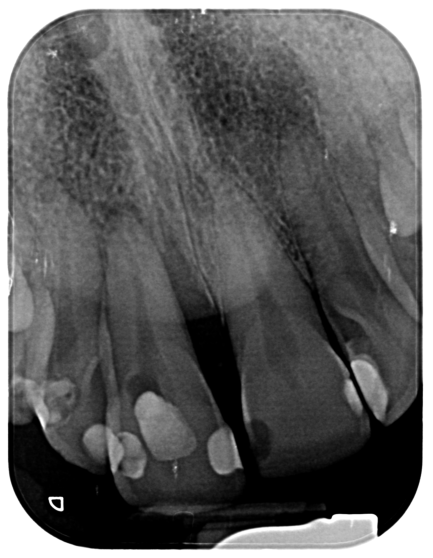

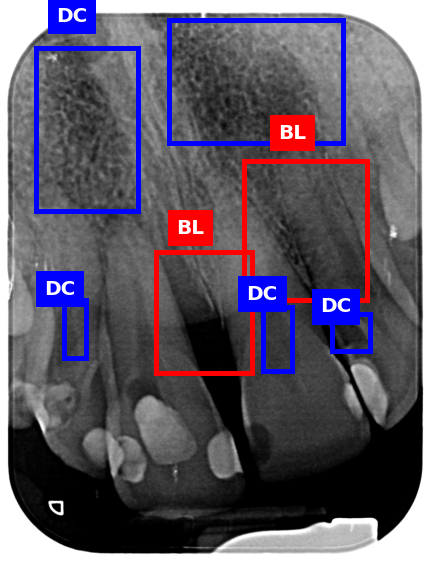

In [119]:
### plot for individual 
### note: some minor changes for two datasets, regarding to img.shape and color

# set the correct directory
data_path = '/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/data/datasets'
label_data_path = 'Zoon_50min_2perImg_IID/labels/train' # or val if want expert labels
image_data_path = 'Zoon_50min_2perImg_IID/images/train' # can change dataset as well
la_path = os.path.join(data_path, label_data_path)
im_path = os.path.join(data_path, image_data_path)

# get list of image name
im_names = os.listdir(im_path) # 'xxx.name.jpg'
im_prefs = [x.rsplit('.', 1)[0] for x in im_names] # 'xxx.name' 

# define class names and color
class_names = ['BL', 'DC']
box_color_map = {'BL':'r', 'DC': 'b'}


# select the image/label and get the dir
t_im = im_prefs[1]
im_filepath = os.path.join(im_path, t_im + '.jpg')
print(im_filepath)
la_filepath = os.path.join(la_path, t_im + '.txt')

# read image
img = mpimg.imread(im_filepath)
# ht, wd, _ = img.shape ##### for within lab dataset
ht, wd = img.shape ##### for zoo dataset
print(img.shape)

# prep the drawing - the background
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
# img_plot = ax.imshow(img) ##### for within lab dataset
img_plot = ax.imshow(img, cmap='gray', vmin=0, vmax=255) ##### for zoo dataset

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
# img_plot = ax.imshow(img) ##### for within lab dataset
img_plot = ax.imshow(img, cmap='gray', vmin=0, vmax=255) ##### for zoo dataset

# read labels
with open(la_filepath, 'r') as f:
    labels = [tuple(map(float, x.strip().split())) for x in f.readlines()]
print(labels)

# read and draw bounding boxes
for label in labels:
    c = class_names[int(label[0])]
    x = label[1]*wd
    y = label[2]*ht
    w = label[3]*wd
    h = label[4]*ht
    px, py, pw, ph = x-w/2, y-h/2, w, h
    box_color = box_color_map[c]
    box = mpatch.Rectangle((px, py), pw, ph, linewidth=5, edgecolor=box_color, facecolor='none')
    ax.add_artist(box)
    text_on_box = c
    _ = ax.annotate(text_on_box, (px+0.5*w, py-0.2*h), # adjust label tag location
                    backgroundcolor=box_color,
                    color='w', weight='bold', 
                    fontsize=20,
                    ha='right',
                    va='center')

# Labels from the expert

/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/data/datasets/Zoon_50min_2perImg_IID/images/val/Unknown-X-20200212-092216-XDBJPMNCZREY-3.jpg
(1244, 1615)
[(0.0, 0.1591331269, 0.154340836, 0.0495356037, 0.1286173633), (0.0, 0.3761609907, 0.1756430868, 0.0922600619, 0.1197749196), (0.0, 0.6281733746, 0.1591639871, 0.0947368421, 0.1302250804), (0.0, 0.7108359133, 0.786977492, 0.0594427245, 0.1028938907), (0.0, 0.4179566563, 0.7560289389, 0.1188854489, 0.1326366559), (1.0, 0.6755417957, 0.6398713826, 0.1213622291, 0.1575562701), (1.0, 0.7678018576, 0.7041800643, 0.0965944272, 0.1254019293), (1.0, 0.8743034056, 0.7371382637, 0.0953560372, 0.1237942122)]


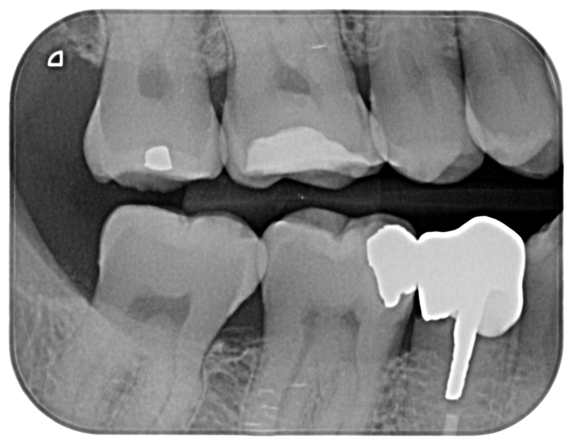

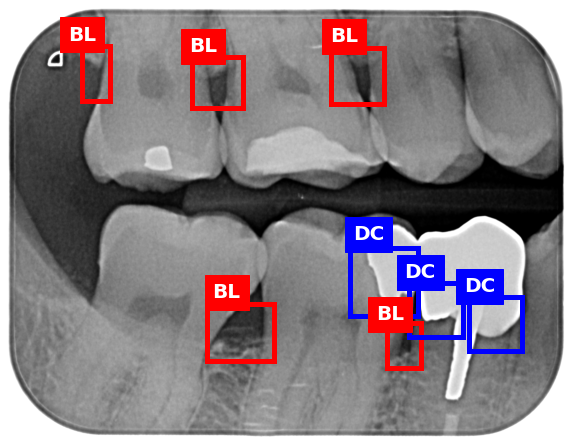

In [211]:
### plot for Johnathon
### note: some minor changes for two datasets, regarding to img.shape and color

# set the correct directory
data_path = '/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/data/datasets'
label_data_path = 'Zoon_50min_2perImg_IID/labels/val' # or val if want expert labels
image_data_path = 'Zoon_50min_2perImg_IID/images/val' # can change dataset as well
la_path = os.path.join(data_path, label_data_path)
im_path = os.path.join(data_path, image_data_path)

# get list of image name
im_names = os.listdir(im_path) # 'xxx.name.jpg'
im_prefs = [x.rsplit('.', 1)[0] for x in im_names] # 'xxx.name' 

# define class names and color
class_names = ['BL', 'DC']
box_color_map = {'BL':'r', 'DC': 'b'}


# select the image/label and get the dir
t_im = im_prefs[22]
im_filepath = os.path.join(im_path, t_im + '.jpg')
print(im_filepath)
la_filepath = os.path.join(la_path, t_im + '.txt')

# read image
img = mpimg.imread(im_filepath)
# ht, wd, _ = img.shape ##### for within lab dataset
ht, wd = img.shape ##### for zoo dataset
print(img.shape)

# prep the drawing - the background
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
# img_plot = ax.imshow(img) ##### for within lab dataset
img_plot = ax.imshow(img, cmap='gray', vmin=0, vmax=255) ##### for zoo dataset

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
# img_plot = ax.imshow(img) ##### for within lab dataset
img_plot = ax.imshow(img, cmap='gray', vmin=0, vmax=255) ##### for zoo dataset

# read labels
with open(la_filepath, 'r') as f:
    labels = [tuple(map(float, x.strip().split())) for x in f.readlines()]
print(labels)

# read and draw bounding boxes
for label in labels:
    c = class_names[int(label[0])]
    x = label[1]*wd
    y = label[2]*ht
    w = label[3]*wd
    h = label[4]*ht
    px, py, pw, ph = x-w/2, y-h/2, w, h
    box_color = box_color_map[c]
    box = mpatch.Rectangle((px, py), pw, ph, linewidth=5, edgecolor=box_color, facecolor='none')
    ax.add_artist(box)
    text_on_box = c
    _ = ax.annotate(text_on_box, (px+0.5*w, py-0.2*h), # adjust label tag location
                    backgroundcolor=box_color,
                    color='w', weight='bold', 
                    fontsize=20,
                    ha='right',
                    va='center')

# Labels from the crowd

In [154]:
### plot for the crowd
### note: some minor changes for two datasets, regarding to img.shape and color
### AND: check the make_up list

# set the correct directory
data_path = '/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/data/datasets'
label_data_path = 'Calc_Removed_New_Test_50min_Crowdsourced/labels/train' # or val if want expert labels
image_data_path = 'Calc_Removed_New_Test_50min_Crowdsourced/images/train' # can change dataset as well
vol_data_path = 'Calc_Removed_New_Test_50min_Crowdsourced/volunteers/train'
la_path = os.path.join(data_path, label_data_path)
im_path = os.path.join(data_path, image_data_path)
vo_path = os.path.join(data_path, vol_data_path)

# get list of image name
im_names = os.listdir(im_path) # 'xxx.name.jpg'
im_prefs = [x.rsplit('.', 1)[0] for x in im_names] # 'xxx.name' 

# define class names and color
class_names = ['BL', 'DC']
box_color_map = {'BL':'r', 'DC': 'b'}

# select the image/label and get the dir
t_im = im_prefs[100]
im_filepath = os.path.join(im_path, t_im + '.jpg')
la_filepath = os.path.join(la_path, t_im + '.txt')
vo_filepath = os.path.join(vo_path, t_im + '.txt')
print(im_filepath)

# read labels
with open(la_filepath, 'r') as f:
    lo_labels = [tuple(map(float, x.strip().split())) for x in f.readlines()]
print(lo_labels)

# read names 
with open(vo_filepath, 'r') as f:
    vo_labels = f.read().splitlines()
print(vo_labels)
uni_vo_labels = sorted(set(vo_labels))
print(uni_vo_labels)
make_up = ['v1', 'v2', 'v3','v4' ,'v5'] ######## need to double check this list


for volunteer in vo_labels:
    ind = uni_vo_labels.index(volunteer)
    ori_ind = vo_labels.index(volunteer)
    vo_labels[ori_ind] = make_up[ind]

print(vo_labels)

/Users/camellia/Desktop/OneDrive - University of Surrey/v3-crowd/data/datasets/Calc_Removed_New_Test_50min_Crowdsourced/images/train/Unknown-X-20200904-112400-XZLX5TYLDIPZ-0.jpg
[(1.0, 0.3944633704, 0.2891330706, 0.0342715542, 0.0346900733), (1.0, 0.6196761583, 0.2071383952, 0.0554871736, 0.0367924695), (0.0, 0.5364453822, 0.1924214158, 0.3671948154, 0.322722648), (0.0, 0.4370483587, 0.7535215141, 0.1706126021, 0.076366508), (0.0, 0.4203449924, 0.2189556954, 0.1646470749, 0.1936161757), (0.0, 0.6708949211, 0.2444112283, 0.1383991006, 0.0686527604), (0.0, 0.660968702, 0.1324675442, 0.0710248908, 0.0748442693), (0.0, 0.2188852255, 0.2368735787, 0.0608417213, 0.1808400897), (0.0, 0.4003201394, 0.2211840499, 0.0481127829, 0.1286424418), (0.0, 0.6642895294, 0.2029363381, 0.0530618424, 0.1858424951), (0.0, 0.0333374282, 0.2359873201, 0.0300507251, 0.2015116232), (1.0, 0.0998062872, 0.3919380041, 0.0428593012, 0.068473194), (1.0, 0.1734735544, 0.3824485743, 0.0589594115, 0.0594956061), (1.0, 

(1509, 1944)


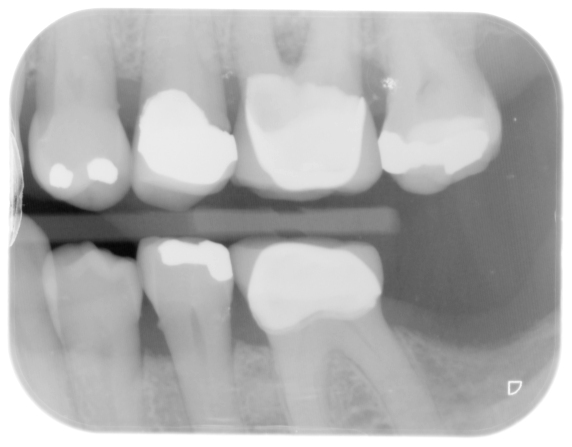

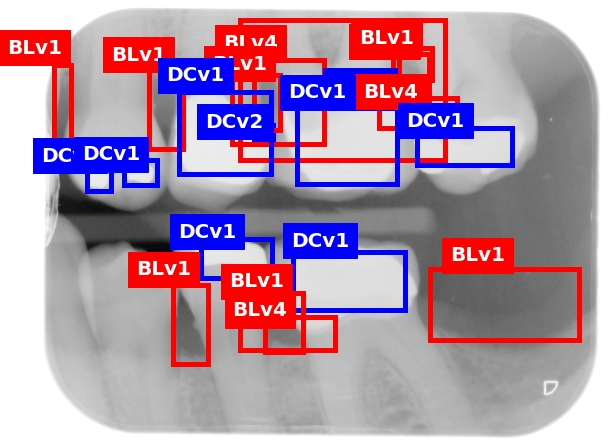

In [155]:
# read image
img = mpimg.imread(im_filepath)
# ht, wd, _ = img.shape ##### for within lab dataset
ht, wd = img.shape ##### for zoo dataset
print(img.shape)

# prep the drawing - the background
fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
# img_plot = ax.imshow(img) ##### for within lab dataset
img_plot = ax.imshow(img, cmap='gray', vmin=0, vmax=255) ##### for zoo dataset

fig, ax = plt.subplots(figsize=(10,10))
ax.axis('off')
# img_plot = ax.imshow(img) ##### for within lab dataset
img_plot = ax.imshow(img, cmap='gray', vmin=0, vmax=255) ##### for zoo dataset

# read and draw bounding boxes
for label in lo_labels:
    ind = lo_labels.index(label)
    c = class_names[int(label[0])]
    x = label[1]*wd
    y = label[2]*ht
    w = label[3]*wd
    h = label[4]*ht
    px, py, pw, ph = x-w/2, y-h/2, w, h
    box_color = box_color_map[c]
    box = mpatch.Rectangle((px, py), pw, ph, linewidth=5, edgecolor=box_color, facecolor='none')
    ax.add_artist(box)
    text_on_box = c + vo_labels[ind]
    _ = ax.annotate(text_on_box, (px+0.5*w, py-0.2*h), # adjust label tag location
                    backgroundcolor=box_color,
                    color='w', weight='bold', 
                    fontsize=20,
                    ha='right',
                    va='center')
